# Linear Regression

# 1. Import the libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# 2. Data preprocessing
- I'll use the bike sharing dataset from UCI Machine Learning Repository.
- The dataset contains the hourly count of rental bikes between years 2017 and 2018 in the Capital Bikeshare system with the corresponding weather and seasonal information.
- First I should convert the data to a usable format, like change the holiday and functioning day  and holiday to 0 and 1
- Also I should convert the season and month to one-hot encoding, then I can use the data to train the model.

In [77]:
file_path = './SeoulBikeData.csv'
bike_data = pd.read_csv(file_path)

# Convert 'Date' to datetime and extract year and month as new features
bike_data['Date'] = pd.to_datetime(bike_data['Date'], format='%d/%m/%Y')
bike_data['Year'] = bike_data['Date'].dt.year
bike_data['Month'] = bike_data['Date'].dt.month

# Drop the 'Date' column as we've extracted usable numerical features
bike_data = bike_data.drop(['Date'], axis=1)

# Perform label encoding on 'Seasons', 'Holiday', and 'Functioning Day'
# Here, I used a simple mapping since these are binary or ordinal categories
holiday_mapping = {'No Holiday': 0, 'Holiday': 1}
functioning_day_mapping = {'Yes': 1, 'No': 0}
seasons_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}

bike_data['Holiday'] = bike_data['Holiday'].map(holiday_mapping)
bike_data['Functioning Day'] = bike_data['Functioning Day'].map(functioning_day_mapping)

# Perform one-hot encoding on 'Seasons', 'Month', and 'Year'
bike_data = pd.get_dummies(bike_data, columns=['Seasons', 'Month', 'Year'], drop_first=False)

bool_mapping = {True: 1, False: 0}
bike_data['Seasons_Autumn'] = bike_data['Seasons_Autumn'].map(bool_mapping)
bike_data['Seasons_Spring'] = bike_data['Seasons_Spring'].map(bool_mapping)
bike_data['Seasons_Summer'] = bike_data['Seasons_Summer'].map(bool_mapping)
bike_data['Seasons_Winter'] = bike_data['Seasons_Winter'].map(bool_mapping)
bike_data['Month_1'] = bike_data['Month_1'].map(bool_mapping)
bike_data['Month_2'] = bike_data['Month_2'].map(bool_mapping)
bike_data['Month_3'] = bike_data['Month_3'].map(bool_mapping)
bike_data['Month_4'] = bike_data['Month_4'].map(bool_mapping)
bike_data['Month_5'] = bike_data['Month_5'].map(bool_mapping)
bike_data['Month_6'] = bike_data['Month_6'].map(bool_mapping)
bike_data['Month_7'] = bike_data['Month_7'].map(bool_mapping)
bike_data['Month_8'] = bike_data['Month_8'].map(bool_mapping)
bike_data['Month_9'] = bike_data['Month_9'].map(bool_mapping)
bike_data['Month_10'] = bike_data['Month_10'].map(bool_mapping)
bike_data['Month_11'] = bike_data['Month_11'].map(bool_mapping)
bike_data['Month_12'] = bike_data['Month_12'].map(bool_mapping)
bike_data['Year_2017'] = bike_data['Year_2017'].map(bool_mapping)
bike_data['Year_2018'] = bike_data['Year_2018'].map(bool_mapping)

# 3. Data Scaled
- I need scale the data before training the model. I'll use the min-max scaler to scale the data.

In [78]:
features_to_standardize = ['Hour', 'Temperature(?C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Dew point temperature(?C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

# Standardize the features
for feature in features_to_standardize:
    mean = bike_data[feature].mean()
    std = bike_data[feature].std()
    bike_data[feature] = (bike_data[feature] - mean) / std

# 4. Data Visualization
## 4.1 Scatter plot

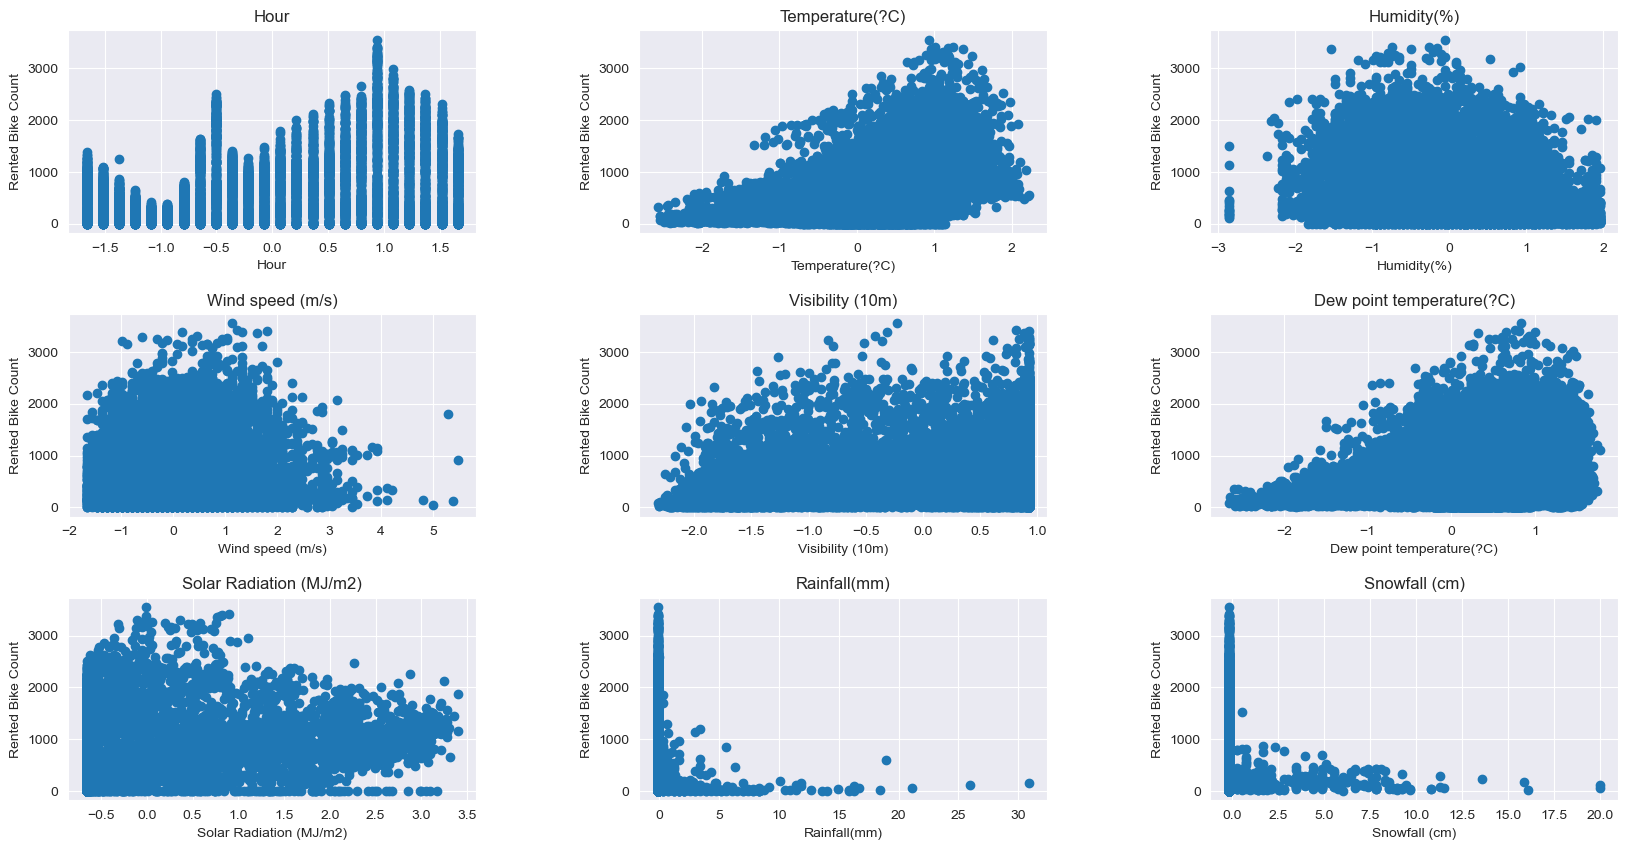

In [79]:
bike_data_labels = ['Hour', 'Temperature(?C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Dew point temperature(?C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.ravel()):
    if i < len(bike_data_labels):
        feature = bike_data_labels[i]
        ax.scatter(bike_data[feature], bike_data['Rented Bike Count'])
        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Rented Bike Count')
    else:
        ax.axis('off')
plt.show()

## 4.2 Correlation
- I'll use the correlation matrix to visualize the correlation between the features and the label.
- The correlation coefficient ranges from -1 to 1.

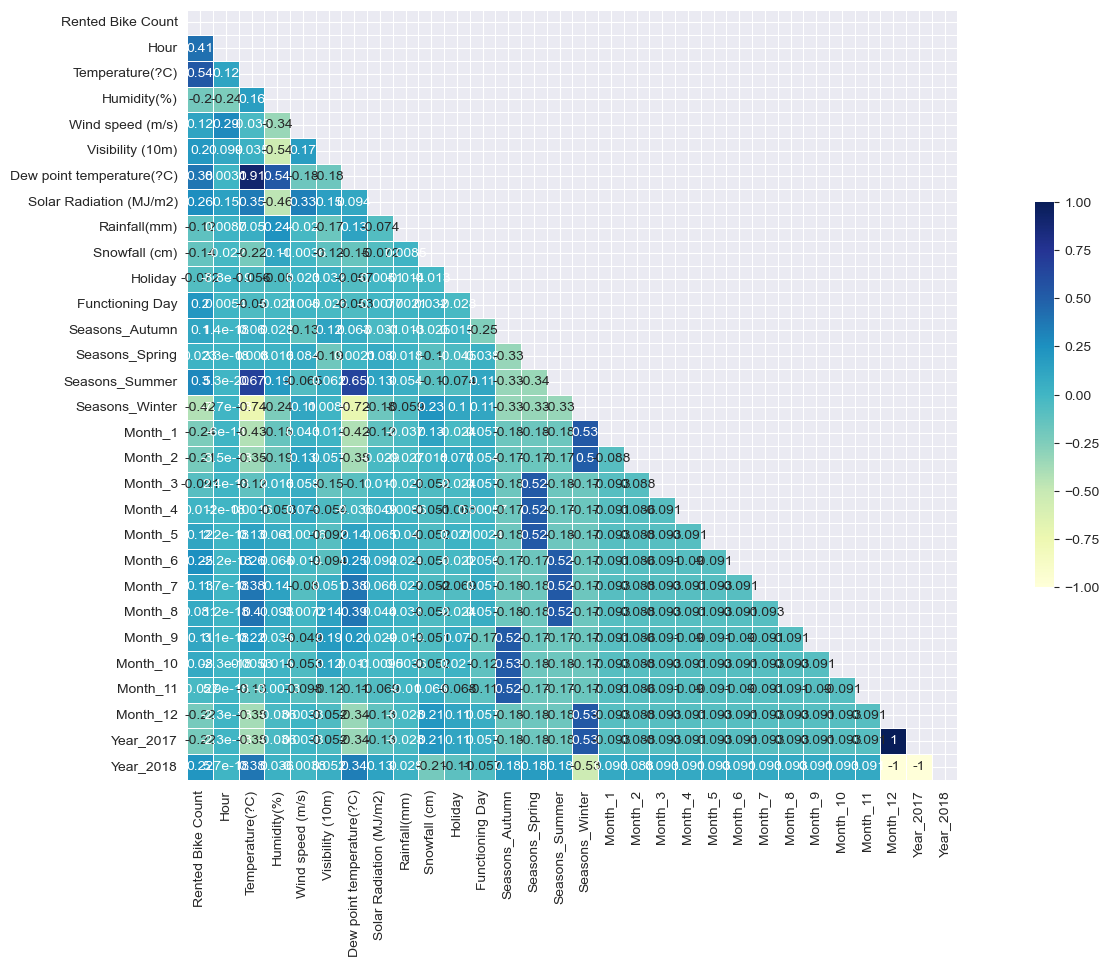

In [80]:
corr = bike_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(20, 10))
cmap = 'YlGnBu'
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

## 4.2 Print the correlation coefficient of the features

In [81]:
corr['Rented Bike Count'].sort_values(ascending=False)
print(corr['Rented Bike Count'].sort_values(ascending=False))

Rented Bike Count            1.000000
Temperature(?C)              0.538558
Hour                         0.410257
Dew point temperature(?C)    0.379788
Seasons_Summer               0.296549
Solar Radiation (MJ/m2)      0.261837
Month_6                      0.251051
Year_2018                    0.215162
Functioning Day              0.203943
Visibility (10m)             0.199280
Month_7                      0.133478
Wind speed (m/s)             0.121108
Month_5                      0.116099
Month_9                      0.107167
Seasons_Autumn               0.102753
Month_8                      0.081053
Month_10                     0.080283
Seasons_Spring               0.022888
Month_4                      0.010899
Month_11                    -0.026807
Holiday                     -0.072338
Month_3                     -0.091190
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
Month_2                     -0.213923
Month_12    

<Axes: title={'center': 'Correlation with target'}>

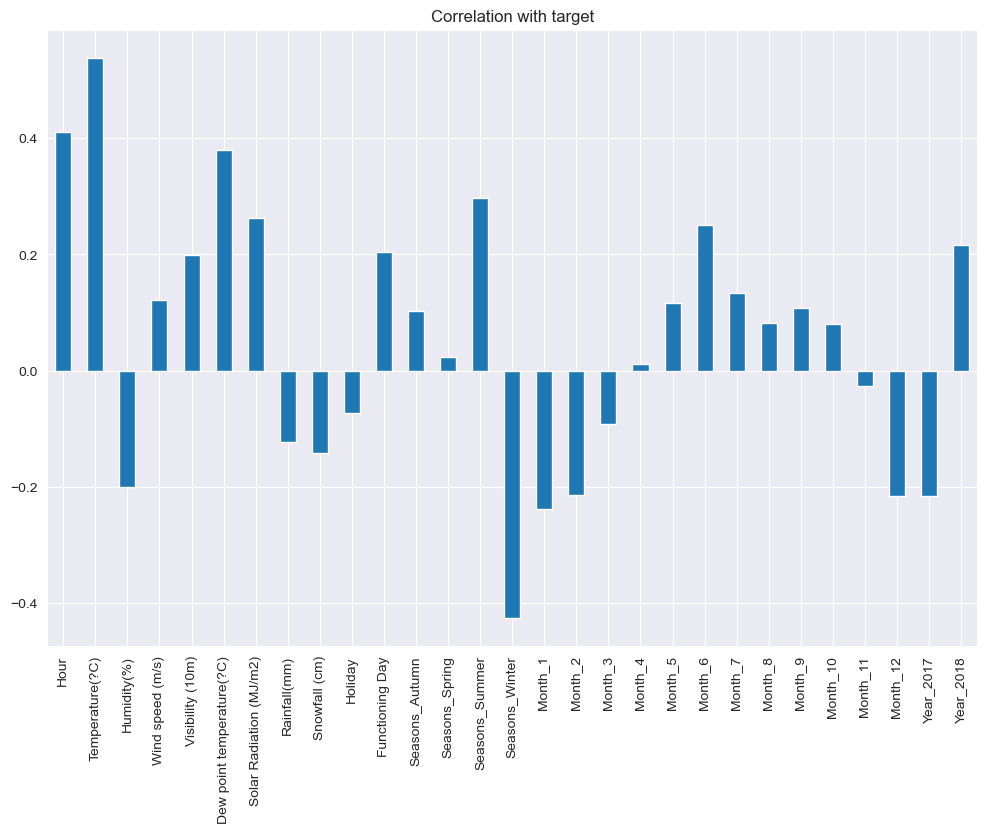

In [82]:
bike_data.drop(['Rented Bike Count'], axis=1).corrwith(bike_data['Rented Bike Count']).plot(kind='bar', grid=True, figsize=(12, 8), title="Correlation with target")

In [83]:
# bike_data.drop(['Wind speed (m/s)', 'Seasons_Summer', 'Holiday','Month_10', 'Month_5'], axis=1)

# 5. Linear Regression
## 5.1 Linear Tools Preparation

In [84]:
def compute_gradients(X, y, predictions):
    """
    Computes the gradients of the cost function with respect to the model parameters.
    :param X: The input features.
    :param y: The actual target values.
    :param predictions: The predicted values from the model.
    :return: The gradients with respect to weights and bias.
    """
    n_samples = len(y)
    dw = np.dot(X.T, (predictions - y)) / n_samples
    db = np.sum(predictions - y) / n_samples
    return dw, db

def compute_cost(predictions, y):
    """
    Computes the cost (mean squared error) between the predictions and the true values.
    :param predictions: The predicted values from the model.
    :param y: The actual target values.
    :return: The computed mean squared error.
    """
    cost = np.mean((predictions - y) ** 2) / 2
    return cost

## 5.2 Linear Regression Class

In [85]:
class LinearRegression:
    """
    Linear Regression class.
    :param learning_rate: The step length that will be taken when following the negative gradient during training.
    :param iterations: The number of iterations to train the model.
    :param w: The weights of the model.
    :param b: The bias of the model.
    :param cost_history: The cost history of the model which will be used to plot the cost over iterations.
    """

    def __init__(self, learning_rate, iterations):
        """
        Initializes the LinearRegression model with specified learning rate and number of iterations.
        :param learning_rate: The learning rate for the model.
        :param iterations: The number of iterations for which the model will be trained.
        """
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = None
        self.cost_history = []

    def initialize_weights(self, n_features):
        """
        Initializes weights and bias to zeros.
        :param n_features: The number of features in the dataset.
        """
        self.w = np.zeros(n_features)
        self.b = 0

    def update_parameters(self, dw, db):
        """
        Updates the model parameters using the computed gradients.
        :param dw: The gradient with respect to weights.
        :param db: The gradient with respect to bias.
        """
        self.w -= self.learning_rate * dw
        self.b -= self.learning_rate * db

    def fit(self, X, y):
        """
        Trains the Linear Regression model using gradient descent.
        :param X: The input features for training.
        :param y: The target values for training.
        """
        n_samples, n_features = X.shape
        self.initialize_weights(n_features)

        for i in range(self.iterations):
            predictions = self.predict(X)

            cost = compute_cost(predictions, y)
            self.cost_history.append(cost)
            if i % 10000 == 0:
                print(f"Cost at iteration {i}: ", cost)

            dw, db = compute_gradients(X, y, predictions)

            self.update_parameters(dw, db)
        
        print({'weights': self.w, 'bias': self.b, 'final cost': cost})

        return self

    def predict(self, X):
        """
        Makes predictions using the linear model.
        :param X: The input features for making predictions.
        :return: The predicted values.
        """
        return np.dot(X, self.w) + self.b

# 6. Train the model
- Now that I have implemented the LinearRegression class, I can train the model.
- I'll use 80% of the data for training and 20% for testing.
- Due the linear regression is regression but my data set is classification, so I need round the predictions to the nearest integer to simulate classification.

## 6.1 Classify the data

In [86]:
# Shuffle the data
bike_data = bike_data.sample(frac=1, random_state=42)

# Split the data
X = bike_data.drop('Rented Bike Count', axis=1).values
y = bike_data['Rented Bike Count'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2 Train the model

In [87]:
linear_regression_model = LinearRegression(0.001, 50000)
linear_regression_model.fit(X_train, y_train)

predictions = linear_regression_model.predict(X_test)

Cost at iteration 0:  460024.17437214614
Cost at iteration 10000:  94407.88079619672
Cost at iteration 20000:  91145.25675203963
Cost at iteration 30000:  89722.22279828819
Cost at iteration 40000:  88903.07675159175
{'weights': array([ 191.12198254,  235.93075671, -199.51908702,   25.77130926,
         35.2363702 ,  125.36184329,  -75.0035559 ,  -76.3784158 ,
         18.51631069, -119.16158081,  686.97558381,  109.6744953 ,
         31.93847802,    3.02819928, -117.2986745 ,  -51.79484011,
        -85.11860074,  -77.6978659 ,  -16.78891058,  126.42525451,
        302.21832637,  -57.2234247 , -241.96670238,  -28.00814275,
        114.42169474,   23.2609433 ,   19.61476635,   19.61476635,
          7.72773176]), 'bias': 27.342498106987065, 'final cost': 88384.50394545727}


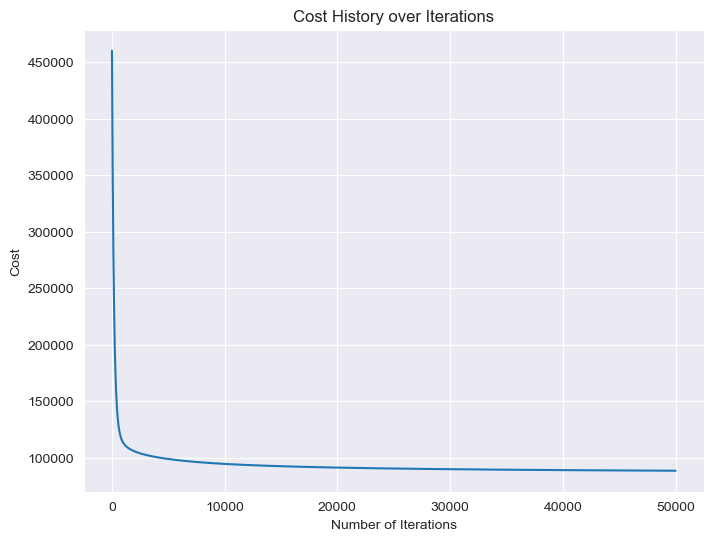

In [88]:
cost_history = linear_regression_model.cost_history
plt.figure(figsize=(8, 6))
plt.plot(cost_history)
plt.title('Cost History over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.show()

# 7. Evaluate the model
## 7.1 Calculate the mse of the model
MSE (Mean Squared Error) is calculated as follows:
$$
\[ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.


In [89]:
def mse(y_true, y_pred):
    """
    The mse function is used to compute the mse of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the mse of the model
    """
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

print(f"MSE: {mse(y_test, predictions):.2f}")

MSE: 157399.09


## 7.2 Calculate the rmse of the model
RMSE (Root Mean Squared Error) is calculated as follows:
$$
\[ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.

In [90]:
def rmse(y_true, y_pred):
    """
    The rmse function is used to compute the rmse of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the rmse of the model
    """
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / len(y_true))

print(f"RMSE: {rmse(y_test, predictions):.2f}")

RMSE: 396.74


## 7.3 Calculate the r2 score of the model

R2 score (coefficient of determination) is calculated as follows:
$$
\[ \text{R2} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( \bar{y} \)$ is the mean of the actual values.

In [91]:
def r2_score(y_true, y_pred):
    """
    The r2_score function is used to compute the r2 score of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the r2 score of the model
    """
    mean = np.mean(y_true)
    ss_tot = np.sum((y_true - mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

print(f"R2 Score: {r2_score(y_test, predictions):.2f}")

R2 Score: 0.60


## 7.4 Calculate the mae of the model
MAE (Mean Absolute Error) is calculated as follows:
$$
\[ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.

In [92]:
def mae(y_true, y_pred):
    """
    The mae function is used to compute the mae of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the mae of the model
    """
    return np.sum(np.abs(y_true - y_pred)) / len(y_true)

print(f"MAE: {mae(y_test, predictions):.2f}")

MAE: 297.61


## 7.5 Modify different iteration times

In [93]:
linear_regression_model1 = LinearRegression(0.001, 500)
linear_regression_model1.fit(X_train, y_train)
predictions1 = linear_regression_model1.predict(X_test)

linear_regression_model2 = LinearRegression(0.001, 1500)
linear_regression_model2.fit(X_train, y_train)
predictions2 = linear_regression_model2.predict(X_test)

linear_regression_model3 = LinearRegression(0.001, 5000)
linear_regression_model3.fit(X_train, y_train)
predictions3 = linear_regression_model3.predict(X_test)

Cost at iteration 0:  460024.17437214614
{'weights': array([ 94.59026291, 105.14562349, -47.02338505,  21.51054884,
        40.95273015,  71.23345383,  41.36651523, -31.33063779,
       -19.62556321,   4.97801085, 180.35627222,  55.68248618,
        45.32975803,  67.69906041,   6.70742209,   0.44902515,
        -0.22763932,   8.35193784,  14.2933487 ,  22.68447149,
        32.1642946 ,  20.58306676,  14.95169904,  20.39310188,
        20.91491606,  14.37446824,   6.48603627,   6.48603627,
       168.93269044]), 'bias': 175.41872671061915, 'final cost': 136342.1562247395}
Cost at iteration 0:  460024.17437214614
{'weights': array([169.48719067, 158.66028162, -89.41674209,  20.45936244,
        57.27417686, 100.95006689,  28.8043185 , -61.35472519,
        -9.88468816,   1.16655551, 237.93297183,  81.69288206,
        56.3983488 ,  83.65904991,  -7.48451364,  -9.05634968,
       -13.13909237,   3.10123916,  16.80529841,  36.49181123,
        59.38835194,  21.41601453,   2.85468345,  25.7

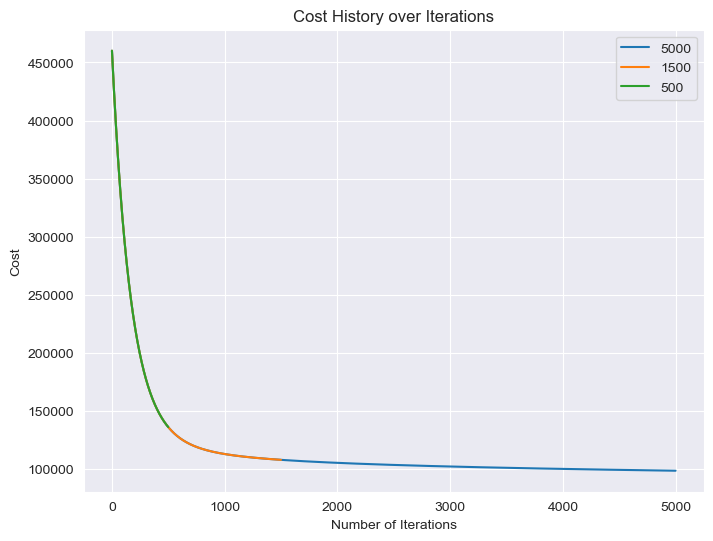

In [94]:
cost_history1 = linear_regression_model1.cost_history
cost_history2 = linear_regression_model2.cost_history
cost_history3 = linear_regression_model3.cost_history
plt.figure(figsize=(8, 6))
plt.plot(cost_history3, label='5000')
plt.plot(cost_history2, label='1500')
plt.plot(cost_history1, label='500')
plt.title('Cost History over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

## 7.6 Modify different learning rate

In [95]:
linear_regression_model4 = LinearRegression(0.0001, 30000)
linear_regression_model4.fit(X_train, y_train)
predictions4 = linear_regression_model4.predict(X_test)

linear_regression_model5 = LinearRegression(0.001, 30000)
linear_regression_model5.fit(X_train, y_train)
predictions5 = linear_regression_model5.predict(X_test)

linear_regression_model6 = LinearRegression(0.01, 30000)
linear_regression_model6.fit(X_train, y_train)
predictions6 = linear_regression_model6.predict(X_test)

linear_regression_model7 = LinearRegression(0.1, 30000)
linear_regression_model7.fit(X_train, y_train)
predictions7 = linear_regression_model7.predict(X_test)

Cost at iteration 0:  460024.17437214614
Cost at iteration 10000:  113128.56072549883
Cost at iteration 20000:  105531.36116702667
{'weights': array([ 199.19454674,  180.54217067, -121.71309046,   12.63672547,
         51.7298151 ,  107.64763625,   -3.70927322,  -76.14140163,
          4.6514992 ,   -6.85050315,  263.33161592,   96.18129189,
         59.37991106,   79.75088128,  -25.37085342,  -21.22055853,
        -29.57680754,   -6.32656701,   15.9996142 ,   49.70686387,
         89.3988618 ,   13.78737029,  -23.43535081,   23.68340379,
         45.6159753 ,   26.8819128 ,   25.42651265,   25.42651265,
        184.51471816]), 'bias': 209.9412308161489, 'final cost': 102385.03040910914}
Cost at iteration 0:  460024.17437214614
Cost at iteration 10000:  94407.88079619672
Cost at iteration 20000:  91145.25675203963
{'weights': array([ 192.28351462,  230.06871487, -200.22043891,   24.28358374,
         31.52731152,  119.62843424,  -73.66457522,  -76.49164437,
         18.71543265,  -97.4

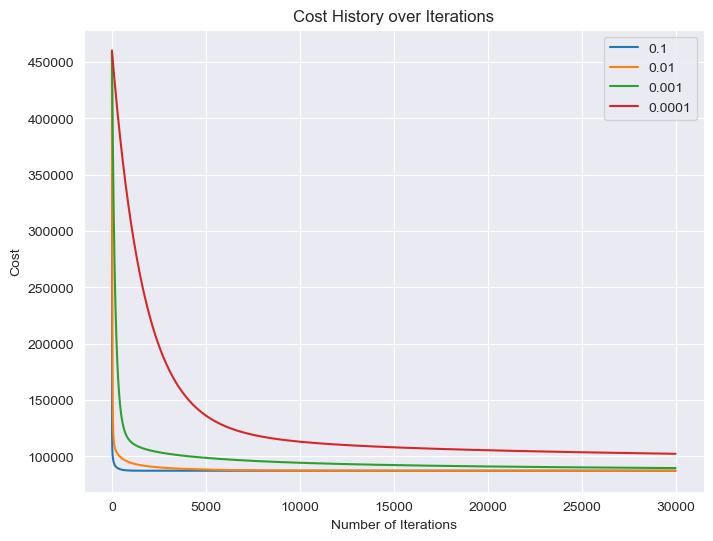

In [96]:
cost_history4 = linear_regression_model4.cost_history
cost_history5 = linear_regression_model5.cost_history
cost_history6 = linear_regression_model6.cost_history
cost_history7 = linear_regression_model7.cost_history
plt.figure(figsize=(8, 6))
plt.plot(cost_history7, label='0.1')
plt.plot(cost_history6, label='0.01')
plt.plot(cost_history5, label='0.001')
plt.plot(cost_history4, label='0.0001')
plt.title('Cost History over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()